# NLP Project - SMS Spam/Ham Detection
## - Ganesh Arumuganainar

### 1. Importing necessary packages

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.model_selection import GridSearchCV
import joblib

### 2. Importing data

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! This dataset is already located in the data folder. The file we are using contains a collection of more than 5 thousand SMS phone messages. You can check out the readme file for more info.

In [4]:
data = pd.read_csv('data/SMSSpamCollection', delimiter='\t', names=['label','message'])
data

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### 3. Data Visualisation

In [5]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

**Length of text messages would be an interesting feature distinguishing spam and ham. So creating a new column 'length'**

In [7]:
data['length'] = data['message'].apply(len)

In [8]:
data

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [10]:
data.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

**There is a text message with 910 characters and one with only 2 characters. These are indeed interesting to look at.** 

In [12]:
data[data['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

**It makes sense that the longest text message is a love message.**

In [13]:
data[data['length'] == 2]['message'].iloc[0]

'Ok'

**And the shortest message is just 'Ok'**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc189be1588>,
      dtype=object)

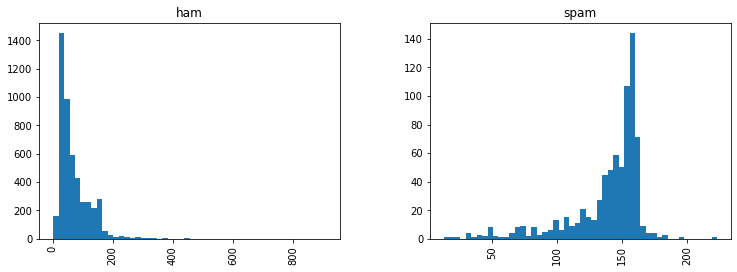

In [14]:
data.hist(column='length', by='label', bins=50, figsize=(12,4))

**The basic exploratory data analysis gave useful trends and insights such that spam messages tend to have longer texts than ham messages**

### 4. Processing 

We'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

In [46]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

###  5. Data split and model training

In [21]:
msg_train, msg_test, label_train, label_test = train_test_split(data['message'], data['label'], test_size=0.2)

In [65]:
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'bow__max_df': [0.25, 0.5, 0.75, 1.0],
              'bow__max_features': [10, 50, 100, 250, 500, 1000, None],
              'bow__stop_words': ('english', None),
              'tfidf__smooth_idf': (True, False),
              'tfidf__norm': ('l1', 'l2', None),
              }

In [66]:
grid = GridSearchCV(pipeline, parameters, cv=2, verbose=1)

In [67]:
grid.fit(msg_train, label_train)

Fitting 2 folds for each of 1344 candidates, totalling 2688 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2688 out of 2688 | elapsed: 410.8min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function text_process at 0x7fc18c194c80>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'bow__max_df': [0.25, 0.5, 0.75, 1.0],
                         'bow__max_features': [10, 50, 100, 250, 500, 1000,
                                               None],
                         'bow__ngram_range': [(1, 1), (1, 2)],
                         'bow__stop_words': ('english', None),
                         'tfidf__norm': ('l1', 'l2', None),
                         'tfidf__smooth_idf': (True, False),
                         'tfidf__use_idf': (True, False)},
             verbose=1)

### 6. Model Evaluation

In [68]:
predictions = grid.best_estimator_.predict(msg_test)

In [69]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       979
        spam       0.94      0.98      0.96       136

    accuracy                           0.99      1115
   macro avg       0.97      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [70]:
print(confusion_matrix(predictions, label_test))

[[970   9]
 [  3 133]]


### 7. Saving the model for future use

In [75]:
joblib.dump(grid.best_estimator_, 'saved_model/SMS_spam_model.pkl')

['saved_model/SMS_spam_model.pkl']

### 8. Loading the saved model and testing

In [76]:
model = joblib.load('saved_model/SMS_spam_model.pkl')

In [78]:
test_text = ['Hurrayyyyy you have won a lottery. Please click on the link to proceed']
model.predict(test_text)

array(['spam'], dtype='<U4')